In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from Common_Functions.processing_functions import data_split

In [46]:
path = os.getcwd()+'/'
print(path)

/Users/shrutikaushal/Documents/GitHub/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot/


# Preparing Data

In [47]:
data = pd.read_csv(path+'Data_Files/JnJ_Files/priv_mcare_f_pay_2022Oct18.csv')
data['group'] = list(map(lambda s: s.replace('\xa0',''), data.group))

cluster_df = pd.read_csv(path+'Kmeans_clusters/clusters_only_using_NormCost.csv')

In [30]:
data_cluster = pd.merge(data, cluster_df, on = 'group')
data_cluster.drop(columns = ['group','priv_pay_iqr'], inplace = True)
data_cluster.dropna(subset = ['msa'], inplace = True)

In [31]:
# splitting data for modeling and future use
data_cluster, future_data = data_split(count_col_name = 'priv_count', data = data_cluster, count_thresh = 34)
# data_cluster.drop(columns = ['priv_pay_mean'], inplace = True)

data_cluster.drop(columns = ['priv_pay_mean','CBSA_NAME'], inplace = True)

In [32]:
data_cluster[data_cluster.site == 'ASC'].shape

(570, 14)

**All rows with any nan values are dropped since linear regression cannot handle it. Performance might improve with imputation**

In [33]:
# creating a list of data frames for each cluster
data_list = [data_cluster[data_cluster.cluster == i].drop(columns = 'cluster').dropna() for i in range(3)]

# Data Visualization

Need to check normality of the target variable. Seems like log-transforming the target for cluster 0 and cluster 2 makes the distribution less skewed. However, cluster 1 shows neglible change and hence the target variable for this cluster should be used as is. Similar conclusion can be made for cluster 0 as well but it requires more testing

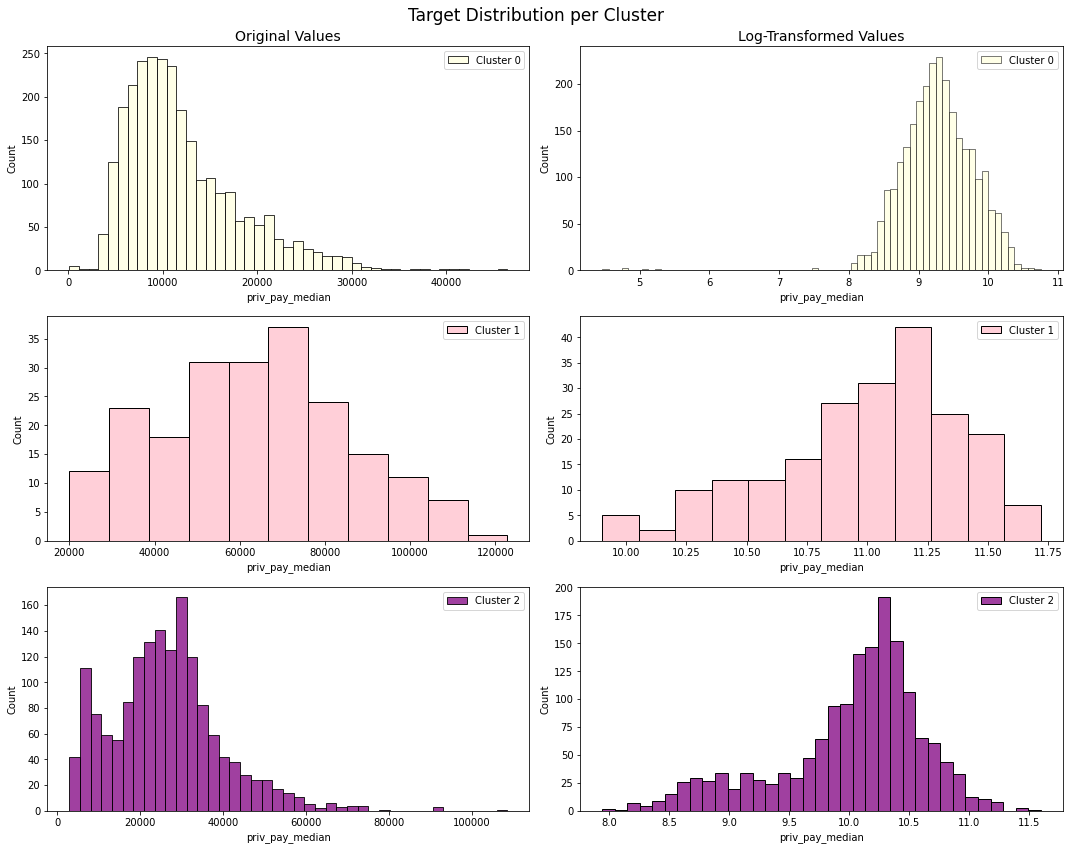

In [34]:
fig,axes = plt.subplots(3,2,figsize = (15,12))
cluster_colors = ['lightyellow','pink','purple']
for i in range(3):
    temp = data_list[i]
    sns.histplot(temp['priv_pay_median'], ax = axes[i,0], label = 'Cluster '+str(i), color = cluster_colors[i])
    axes[i,0].legend()
    sns.histplot(np.log(temp['priv_pay_median']), ax = axes[i,1], label = 'Cluster '+str(i),\
                color = cluster_colors[i])
    axes[i,1].legend()
    
cols = ['Original Values','Log-Transformed Values']
rows = ['Cluster 0', 'Cluster 1', 'Cluster 2']

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize = 14)

fig.suptitle('Target Distribution per Cluster', fontsize = 17)
fig.tight_layout()
plt.savefig(path+'figures/linear_models/target_dist_perCluster.png', bbox_inches = 'tight')
plt.show()


# Modeling

## Train-Test Split

In [35]:
target_list = [data_list[i][['priv_pay_median']] \
               for i in range(3)]
log_target_list = [np.log(data_list[i][['priv_pay_median']]) \
               for i in range(3)]
# dropping nan values
data_list_var = [data_list[i].copy().drop(columns = ['priv_pay_median', 'State']) \
                for i in range(3)]

In [36]:
data_splits = []
for i in range(3):
    dev_X, test_X, dev_y, test_y = train_test_split(data_list_var[i], target_list[i],\
                                                    test_size = 0.2, random_state = 42)
    data_splits.append([(dev_X, dev_y),(test_X, test_y)])

In [37]:
log_data_splits = []
for i in range(3):
    dev_X, test_X, dev_y, test_y = train_test_split(data_list_var[i], log_target_list[i],\
                                                    test_size = 0.2, random_state = 42)
    log_data_splits.append([(dev_X, dev_y),(test_X, test_y)])

## Encoding Categorical Variables

There are two 2 categorical variables that need to be encoded - site and CBSA_NAME. I propose using one hot encoding for the former and target encoding for the later given the levels within each feature.

In [38]:
# preprocess = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),['site']),\
#                                     (TargetEncoder(handle_unknown = 'value'),['CBSA_NAME']),\
#                                     remainder = 'passthrough')

preprocess = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'),['site']),\
                                    remainder = 'passthrough')

## Models

### Linear Regression

#### Original

In [39]:
pipe_linear = make_pipeline(preprocess, LinearRegression())
for i in range(3):
    dev_X, dev_y = data_splits[i][0]
    scores_linear = cross_val_score(pipe_linear, dev_X, dev_y, cv = 5, \
                                    scoring = 'neg_mean_absolute_percentage_error',\
                                   error_score = 'raise')
    print('MAPE for Cluster '+ str(i)+' = '+ str(-np.mean(scores_linear)*100))

MAPE for Cluster 0 = 44.57688462232484
MAPE for Cluster 1 = 22.365952265999205
MAPE for Cluster 2 = 31.12464600306807


##### Checking Homodescasticity

Cluster 0
Train MAPE values = 0.44371972406654137
Test MAPE values = 0.38418196839924695
R2 = 0.43771384987048445


Cluster 1
Train MAPE values = 0.20558127099448276
Test MAPE values = 0.18206996139299378
R2 = 0.615224041709268


Cluster 2
Train MAPE values = 0.30708377326130526
Test MAPE values = 0.29346424275548255
R2 = 0.5341699074811728




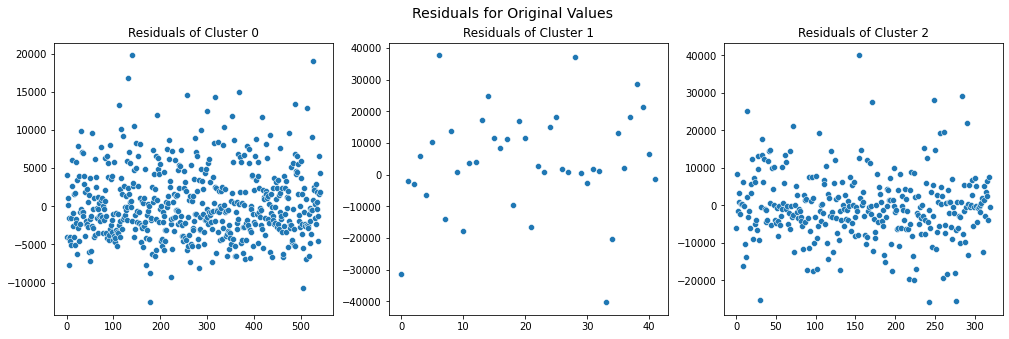

In [40]:
fig, axes = plt.subplots(1,3, figsize = (17,5))
for i in range(3):
    dev_X, dev_y = data_splits[i][0]
    test_X, test_y = data_splits[i][1]
    dev_X_transformed = preprocess.fit_transform(dev_X, dev_y)
    test_X_transformed = preprocess.fit_transform(test_X, test_y)

    model = LinearRegression().fit(dev_X_transformed, dev_y)
    model.score(dev_X_transformed, dev_y)
    l = test_y.values - model.predict(test_X_transformed)
    l = l.reshape(1,-1)[0]
    
    test = test_y.values
    dev = dev_y.values
    test_predicted = model.predict(test_X_transformed)
    dev_predicted = model.predict(dev_X_transformed)
    print('Cluster '+str(i))
    print('Train MAPE values = '+str(mean_absolute_percentage_error(dev, dev_predicted)))
    print('Test MAPE values = '+str(mean_absolute_percentage_error(test, test_predicted)))
    print('R2 = '+ str(model.score(dev_X_transformed, dev_y)))
    print('\n')
    
    sns.scatterplot(x = np.arange(len(test_y)), y = l, ax = axes[i])
    axes[i].set_title('Residuals of Cluster '+ str(i))
    plt.suptitle('Residuals for Original Values', fontsize = 14)
plt.savefig(path+'figures/linear_models/original_homodescasticity.png', bbox_inches = 'tight')

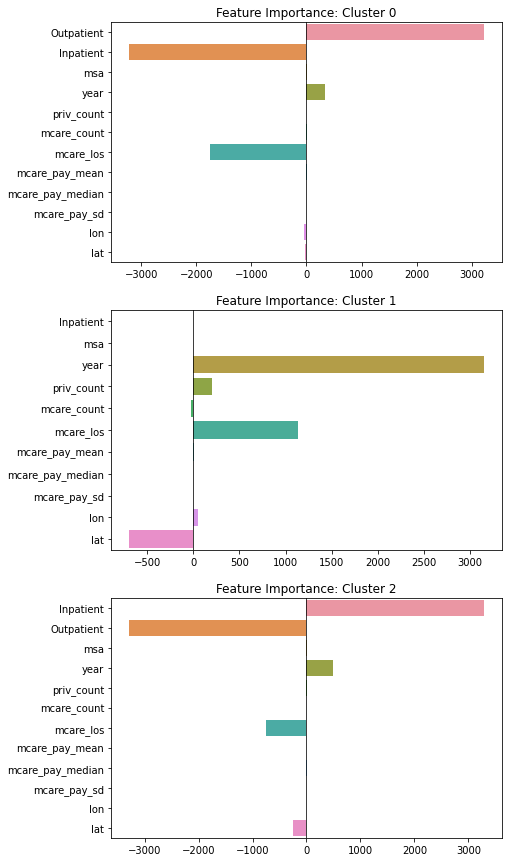

In [41]:
fig, axes = plt.subplots(3,1, figsize = (7,15))
for i in range(3):
    dev_X, dev_y = data_splits[i][0]
    test_X, test_y = data_splits[i][1]
    dev_X_transformed = preprocess.fit_transform(dev_X, dev_y)
    test_X_transformed = preprocess.fit_transform(test_X, test_y)
    model = LinearRegression().fit(dev_X_transformed, dev_y)
    
#     feature_names = list(dev_X.site.unique()) + ['CBSA_NAME'] + \
#     dev_X.drop(columns = ['site','CBSA_NAME']).columns.to_list()
    
    feature_names = list(dev_X.site.unique()) +  \
    dev_X.drop(columns = ['site']).columns.to_list()
    
    coeffs = model.coef_
    axes[i].axvline(x = 0, color = 'black', linewidth = 0.75)
    g = sns.barplot(y = feature_names, x = coeffs[0], ax = axes[i])
    axes[i].set_title('Feature Importance: Cluster '+ str(i))
plt.savefig(path+'figures/linear_models/original_feature_imp.png', bbox_inches = 'tight') 

#### Log-Transformed

In [42]:
pipe_linear = make_pipeline(preprocess, LinearRegression())
for i in range(3):
    dev_X, dev_y = log_data_splits[i][0]
    scores_linear = cross_val_score(pipe_linear, dev_X, dev_y, cv = 5, \
                                    scoring = 'neg_mean_absolute_percentage_error',\
                                   error_score = 'raise')
    print('MAPE for Cluster '+ str(i)+' = '+ str(-np.mean(scores_linear)*100))

MAPE for Cluster 0 = 3.4517681022708397
MAPE for Cluster 1 = 1.9514509048833344
MAPE for Cluster 2 = 2.874452974518329


##### Checking Homodescasticity

Cluster 0
Train MAPE values = 0.42304199249252156
Test MAPE values = 0.3648687431531081
R2 = 0.34253312766844746


Cluster 1
Train MAPE values = 0.20355733891040761
Test MAPE values = 0.20811972433957765
R2 = 0.6093687900635694


Cluster 2
Train MAPE values = 0.3008953946686942
Test MAPE values = 0.28624426497326816
R2 = 0.6442530970064014




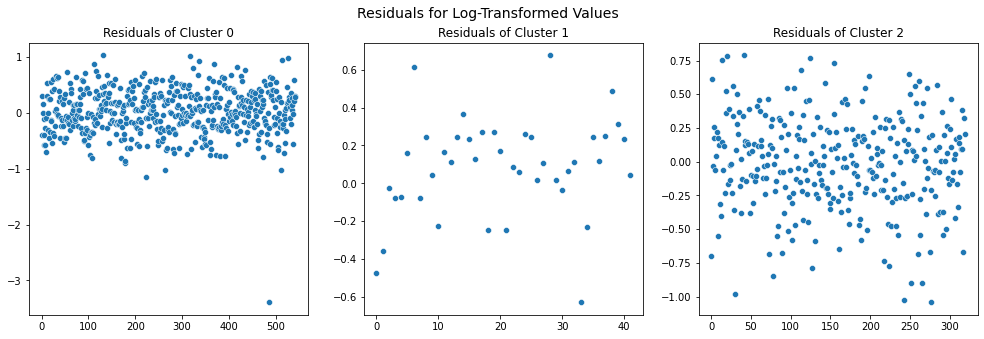

In [43]:
fig, axes = plt.subplots(1,3, figsize = (17,5))
coeffs = []
for i in range(3):
    dev_X, dev_y = log_data_splits[i][0]
    test_X, test_y = log_data_splits[i][1]
    dev_X_transformed = preprocess.fit_transform(dev_X, dev_y)
    test_X_transformed = preprocess.fit_transform(test_X, test_y)
    model = LinearRegression().fit(dev_X_transformed, dev_y)
    model.score(dev_X_transformed, dev_y)
    l = test_y.values - model.predict(test_X_transformed)
    l = l.reshape(1,-1)[0]
    
    test = np.exp(test_y.values)
    dev = np.exp(dev_y.values)
    test_predicted = np.exp(model.predict(test_X_transformed))
    dev_predicted = np.exp(model.predict(dev_X_transformed))
    print('Cluster '+str(i))
    print('Train MAPE values = '+str(mean_absolute_percentage_error(dev, dev_predicted)))
    print('Test MAPE values = '+str(mean_absolute_percentage_error(test, test_predicted)))
    print('R2 = '+ str(model.score(dev_X_transformed, dev_y)))
    print('\n')
    
    coeffs.append(model.coef_)
    
    sns.scatterplot(x = np.arange(len(test_y)), y = l, ax = axes[i])
    axes[i].set_title('Residuals of Cluster '+ str(i))
    plt.suptitle('Residuals for Log-Transformed Values', fontsize = 14)
plt.savefig(path+'figures/linear_models/log_homodescasticity.png', bbox_inches = 'tight')

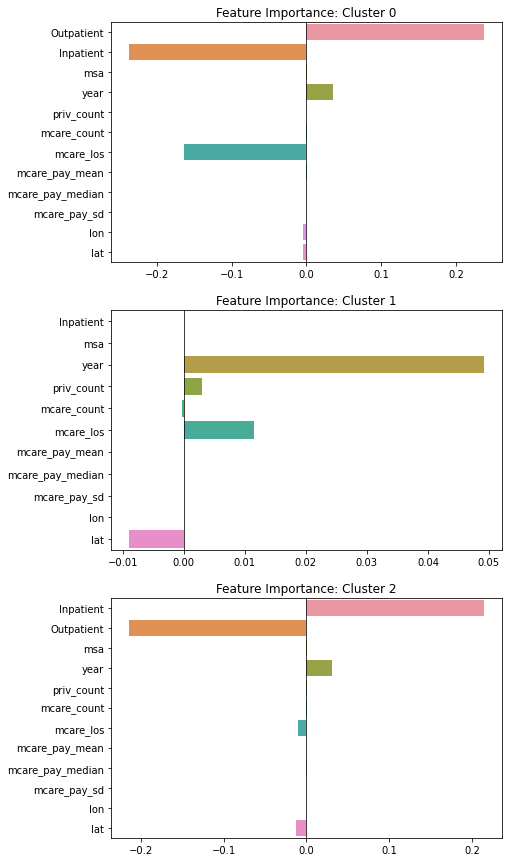

In [44]:
fig, axes = plt.subplots(3,1, figsize = (7,15))
for i in range(3):
    dev_X, dev_y = log_data_splits[i][0]
    test_X, test_y = log_data_splits[i][1]
    dev_X_transformed = preprocess.fit_transform(dev_X, dev_y)
    test_X_transformed = preprocess.fit_transform(test_X, test_y)
    model = LinearRegression().fit(dev_X_transformed, dev_y)
    
#     feature_names = list(dev_X.site.unique()) + ['CBSA_NAME']+\
#     dev_X.drop(columns = ['site','CBSA_NAME']).columns.to_list()
    
    feature_names = list(dev_X.site.unique()) +  \
    dev_X.drop(columns = ['site']).columns.to_list()
    
    coeffs = model.coef_
    axes[i].axvline(x = 0, color = 'black', linewidth = 0.75)
    g = sns.barplot(y = feature_names, x = coeffs[0], ax = axes[i])
    axes[i].set_title('Feature Importance: Cluster '+ str(i))
plt.savefig(path+'figures/linear_models/log_feature_imp.png', bbox_inches = 'tight')